In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [2]:
data_dir = 'datasets/train'
image_size = 224
batch_size = 32
num_classes = 2
train_ratio = 0.8

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
print(f"Kelas yang terdeteksi: {class_names}")

train_size = int(train_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Kelas yang terdeteksi: ['rose', 'sunflower']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 11.18M
Trainable parameters: 11.18M


In [4]:
epochs = 10
train_losses, val_losses = [], []
val_accs = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}, Val Acc {val_acc:.4f}")

Epoch 1: Train Loss 0.4359, Val Loss 5.7135, Val Acc 0.5750
Epoch 2: Train Loss 0.2377, Val Loss 1.0412, Val Acc 0.7500
Epoch 3: Train Loss 0.1702, Val Loss 0.1436, Val Acc 0.9500
Epoch 4: Train Loss 0.0370, Val Loss 1.6687, Val Acc 0.8500
Epoch 5: Train Loss 0.0084, Val Loss 0.9493, Val Acc 0.9000
Epoch 6: Train Loss 0.0051, Val Loss 0.4471, Val Acc 0.9750
Epoch 7: Train Loss 0.0163, Val Loss 0.4028, Val Acc 0.9250
Epoch 8: Train Loss 0.0048, Val Loss 0.3876, Val Acc 0.9000
Epoch 9: Train Loss 0.0096, Val Loss 0.8526, Val Acc 0.8500
Epoch 10: Train Loss 0.0380, Val Loss 0.0604, Val Acc 0.9750


In [5]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'val_loss': val_losses,
}, 'flower_classifier_checkpoint.pth')

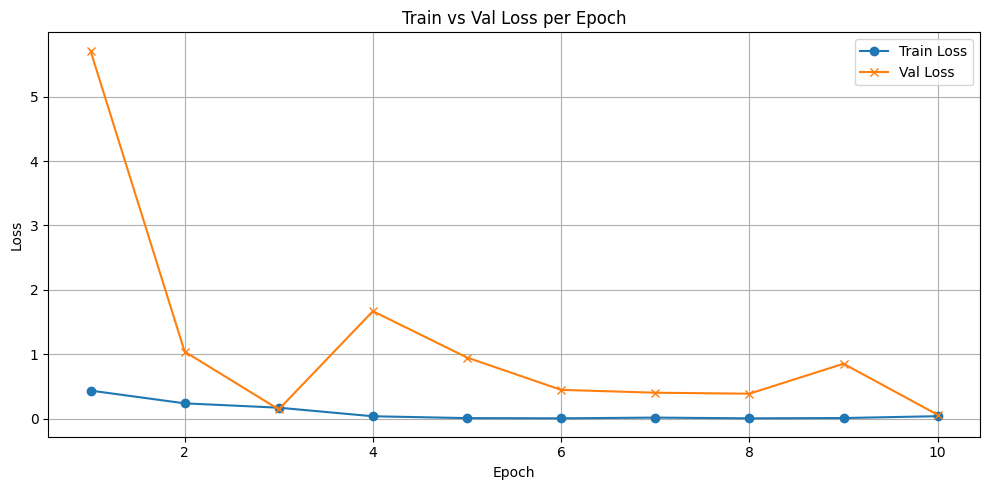

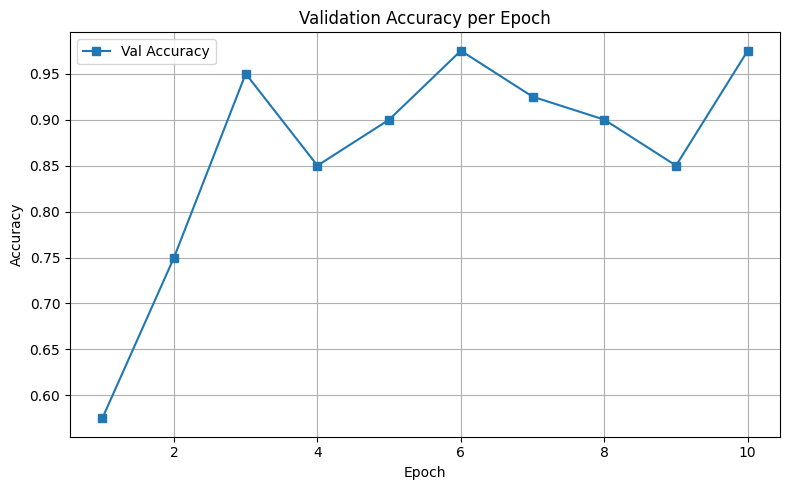

In [6]:
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Val Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

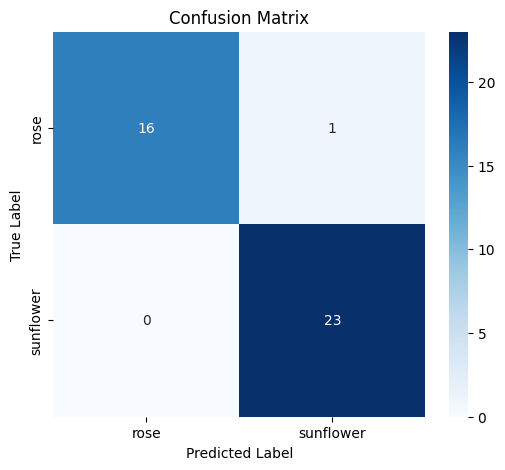

In [7]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Prediction: rose


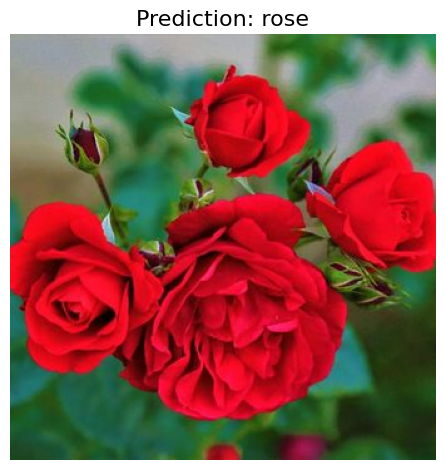

In [8]:
def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)
    predicted_class = class_names[pred.item()]
    return predicted_class, image

# Contoh penggunaan:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = full_dataset.classes
model = load_model('flower_classifier_checkpoint.pth', num_classes=len(class_names), device=device)
img_path = 'datasets/test/mawartest.jpg'  # path data uji
predicted_label, image = predict_image(img_path, model, device, class_names)
print(f"Prediction: {predicted_label}")
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediction: {predicted_label}", fontsize=16)
plt.tight_layout()
plt.show()